<a href="https://colab.research.google.com/github/lyeslehara1996/AngularSpringBoot/blob/main/Resultats_avec350echantillant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.optimizers import Adam,Adamax,Adagrad,SGD,RMSprop
import keras.metrics as metrics
from keras import backend as K
from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM,GRU, RepeatVector, TimeDistributed, Layer, Activation, Dropout
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from tensorflow import  keras
import pandas as pd 
import re 
import nltk


import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import zeros
from keras.layers import Dropout

from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
import string as st
SAVEd = False


from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
nltk.download('stopwords')
nltk.download('punkt')
""" Dataset"""

from keras.wrappers.scikit_learn import KerasClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from tensorflow.python.framework.ops import disable_eager_execution

# import tensorflow as tf
from tensorflow.python.eager.context import eager_mode, graph_mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:

df=pd.read_excel("/content/drive/MyDrive/dossier_de_travail/SemEval2017A.xlsx")

df.drop("Unnamed: 3", axis=1, inplace=True)
df.drop("Unnamed: 4", axis=1, inplace=True)
df.drop("Unnamed: 5", axis=1, inplace=True)
df.drop("Unnamed: 6", axis=1, inplace=True)

df.head()


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20633 entries, 0 to 20632
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        20633 non-null  object
 1   Polarity  20632 non-null  object
 2   Comments  20632 non-null  object
dtypes: object(3)
memory usage: 483.7+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20632 entries, 0 to 20632
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        20632 non-null  object
 1   Polarity  20632 non-null  object
 2   Comments  20632 non-null  object
dtypes: object(3)
memory usage: 644.8+ KB


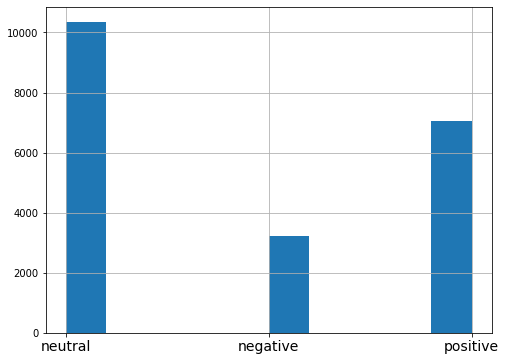

,ID,Polarity,Comments
0,619950566786113024,neutral,"picturehouse's, pink floyd's, 'roger waters: t..."
1,619969366986235008,neutral,order go set a watchman in store or through ou...
2,619971047195044992,negative,if these runway renovations at the airport pre...
3,619974445185302016,neutral,if you could ask an onstage interview question...
4,619987808317406976,positive,a portion of book sales from our harper lee/go...


In [5]:

#supprimer les lignes qui contient des valeur null 
df.Polarity.unique()
df.dropna(subset=['Polarity'], inplace=True)
df.Polarity.unique()
df.info()


plt.figure(figsize=(8,6))
df.Polarity.hist(xlabelsize=14)
plt.show()

#### transformet les mots en miniscule ######
df.Comments=df.Comments.str.lower()
df.head()

In [6]:

###################STOP WORDS################
#STOP WORDS
#Tokenization of text

tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['Comments']=df['Comments'].apply(remove_stopwords)

In [7]:

############supprission des caractere spiciaux Dans Commantaire #########
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'{link}', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'&[a-z]+;', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r"[^a-z]", ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'@mention', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: " ".join(x.lower() for x in str(x).split()  if len(x)>3 ))

In [8]:
#######deviser en review and labels ######


reviews =  df[['Comments']]
labels =  df[['Polarity']]

corpus= []
for text in reviews['Comments']:
    words= [word.lower() for word in word_tokenize(text)]
    corpus.append(words)

num_words=len(corpus)
print(num_words)

20632


In [9]:
####reviews sans ponctuation #######

revue_sans_ponctuation=[]
for sentence in reviews['Comments']:

    revue_sans_ponctuation.append(' '.join(Word.strip(st.punctuation) for Word in sentence.split()))

reviews_cleaned = np.asarray(revue_sans_ponctuation)
reviews_cleaned



review_array = np.asarray(revue_sans_ponctuation)
label_array = np.asarray(labels['Polarity'])

reviews_labels = np.stack((review_array, label_array), axis = 1)

reviews_labels

array([['picturehouse pink floyd roger waters walll opening sept making waves watch trailer rolling stone look',
        'neutral'],
       ['order watchman store website tuesday half price gsaw gsawatchmanbook',
        'neutral'],
       ['runway renovations airport prevent seeing taylor swift monday blood meaning',
        'negative'],
       ...,
       ['hours arrived saudi arabia tuesday turkish president recep tayyip erdogan accused syria president mercilessly',
        'neutral'],
       ['vanityfair alex kardashian worth love kardashian conure',
        'negative'],
       ['guess even pandora knows justin bieber grown condom played',
        'neutral']], dtype=object)

In [10]:
########Encoder les polarity  ##############
encoder = LabelEncoder()
encoder.fit(label_array)
encoded_labels = encoder.transform(label_array)
encoded_labels = to_categorical(encoded_labels)
encoded_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [11]:
##### Train and Test
review_train, review_test, label_train, label_test = train_test_split(reviews_cleaned, encoded_labels, test_size=0.20, random_state=42)
print(review_train.shape, label_train.shape)
print(review_test.shape, label_test.shape)

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1

(16505,) (16505, 3)
(4127,) (4127, 3)


In [12]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/dossier_de_travail/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
print(embedding_matrix[1].shape)

(100,)


In [13]:
X_train=review_train  
X_test=review_test
y_train=label_train   
y_test=label_test
MAX_LENGTH = 100
NUM_WORDS = vocab_size
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LENGTH)

train_index = np.random.choice(np.arange(X_train.shape[0]), 350, replace=False)     
test_index = np.random.choice(np.arange(X_test.shape[0]), 250, replace=False)      

X_train = X_train[train_index]
y_train = y_train[train_index]

X_test = X_test[test_index]
y_test = y_test[test_index]

temp = np.zeros((X_train.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_train.shape[0]), axis=0).reshape(X_train.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_train.shape[0], axis=0), X_train] = 1

Conversion_X_train = temp

temp = np.zeros((X_test.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_test.shape[0]), axis=0).reshape(X_test.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_test.shape[0], axis=0), X_test] = 1

Conversion_X_test = temp
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)
print(Conversion_X_train.shape)
print(Conversion_X_test.shape)


X_train (350, 100)
y_train (350, 3)
X_test (250, 100)
y_test (250, 3)
(350, 100, 22814)
(250, 100, 22814)


In [14]:

from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [15]:

class AttentionCouche(tf.keras.layers.Layer): 
    def __init__(self, **kwargs):   
        self.dim_mots = 200
        self.unite_par_seq =100 

        super(AttentionCouche, self).__init__( **kwargs)
        
    def build(self, input_shape):

        dim_mots = input_shape[-1] 
        unite_par_seq = input_shape[-2]
        num_units = 1
        
        self.w = self.add_weight(name='attention_weigth',shape=(input_shape[-1],1), initializer='normal')            
        self.b = self.add_weight(name='attention_bias',shape=(input_shape[-2],1), initializer='zero')
       
        
        super(AttentionCouche, self).build(input_shape)
        
    def call(self, x):
       e=K.tanh(K.dot(x,self.w)+self.b) 
       e = Flatten()(e) 
       a = Activation('softmax')(e)
       temp = RepeatVector(2048)(a) 
       temp = Permute([2,1])(temp) 
       output = Multiply()([x,temp]) 
       output = Lambda(lambda values: K.sum(values, axis=1))(output)
       return output
    def output_shep(self,input_shape):
      return (input_shape[0],input_shape[-1])
    def get_config(self):
      return super(AttentionCouche,self).get_config()

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
	
	
  #metrics=['acc',f1_m,precision_m, recall_m]

# **Test_1** 
Une Couche a 250 Neurones

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/A_ameliorer_2'
MODEL_FILE_NAME = 'Test1.h5'
LR=0.0001

batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)

def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(250, return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()

def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)
    
encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional( LSTM(250, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     2281400     ['input_3[0][0]']                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 100, 500)    702000      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 attention_couche_1 (AttentionC  (None, 500)         600         ['bidirectional_3[0][0]']  

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 0.7390 - decoded_mean_loss: 0.0484 - pred_loss: 0.6903 - decoded_mean_acc: 0.0000e+00 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/A_ameliorer_2/Test1.h5
350/350 [==============================] - 78s 222ms/sample - loss: 0.7390 - decoded_mean_loss: 0.0484 - pred_loss: 0.6903 - decoded_mean_acc: 0.0000e+00 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 - val_loss: 0.7357 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6875 - val_decoded_mean_acc: 1.6000e-04 - val_decoded_mean_f1_m: 0.0000e+00 - val_decoded_mean_precision_m: 0.0000e+00 - val_decoded_mean_recall_m: 0.0000e+00 - val_pred_acc: 0.6667 - val_pred_f1_m: 0.0000e+00 - val_pred_precision_m: 0.0000e+00 - val_pred_recall_m: 0.0000e+00
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.7326 - decoded_mean_loss: 0.0484 - pred_loss: 0.6838 - decoded_mean_acc: 0.0036 - decoded_mean_f1

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.611509961605072,
 0.011946922,
 0.59804296,
 0.93292,
 0.9303827,
 0.98003167,
 0.88552886,
 0.6853334,
 0.50584596,
 0.5318134,
 0.48347357]

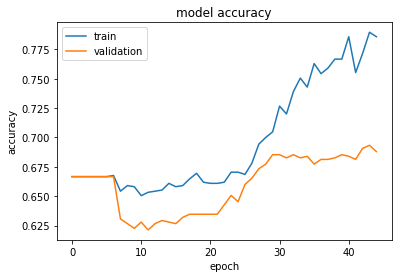

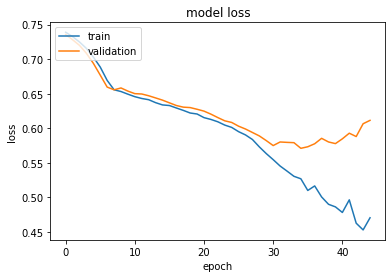

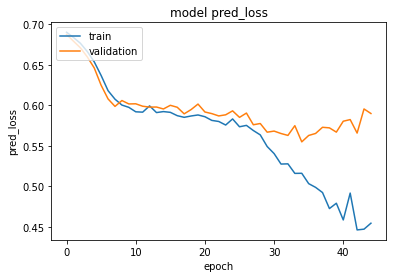

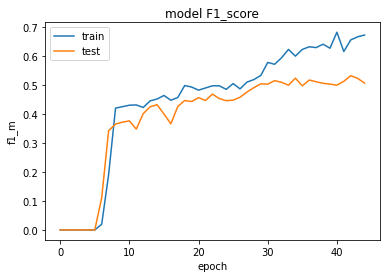

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Test 2:
avec une couche cache avec 500 Neurones

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/Models_a_ameliorer'
MODEL_FILE_NAME = 'Test_2.h5'
LR=0.0001

batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()
def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =Bidirectional(LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     2281400     ['input_5[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 100, 1000)   2404000     ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 attention_couche_2 (AttentionC  (None, 1000)        1100        ['bidirectional_6[0][0]']  

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 0.7357 - decoded_mean_loss: 0.0484 - pred_loss: 0.6866 - decoded_mean_acc: 0.0026 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/Models_a_ameliorer/Test_2.h5
350/350 [==============================] - 115s 330ms/sample - loss: 0.7357 - decoded_mean_loss: 0.0484 - pred_loss: 0.6866 - decoded_mean_acc: 0.0026 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 - val_loss: 0.7275 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6790 - val_decoded_mean_acc: 0.1127 - val_decoded_mean_f1_m: 0.0000e+00 - val_decoded_mean_precision_m: 0.0000e+00 - val_decoded_mean_recall_m: 0.0000e+00 - val_pred_acc: 0.6667 - val_pred_f1_m: 0.0000e+00 - val_pred_precision_m: 0.0000e+00 - val_pred_recall_m: 0.0000e+00
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.7235 - decoded_mean_loss: 0.0484 - pred_loss: 0.6746 - decoded_mean_acc: 0.2289 - decoded_mean_f1_

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.6042301182746888,
 0.012019209,
 0.59083384,
 0.93292,
 0.9350605,
 0.9889531,
 0.88675183,
 0.6986667,
 0.533476,
 0.5521976,
 0.51652646]

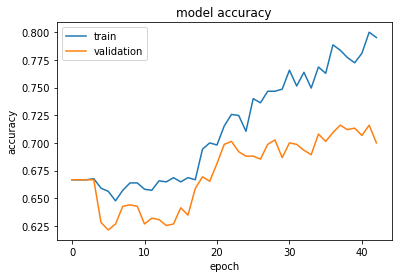

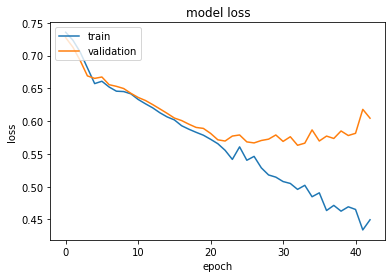

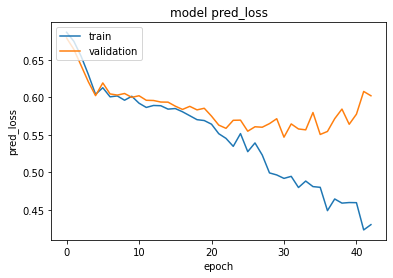

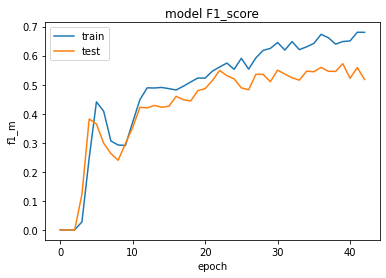

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# **Test_3**:
 Une couche avec 750 Neurones

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/Resultat'
MODEL_FILE_NAME = 'Test_3.h5'
LR=0.0001

batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(750, return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()
def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =Bidirectional(LSTM(750, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 100)     2281400     ['input_7[0][0]']                
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 100, 1500)   5106000     ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 attention_couche_4 (AttentionC  (None, 1500)        1600        ['bidirectional_8[0][0]']  

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 0.7355 - decoded_mean_loss: 0.0484 - pred_loss: 0.6864 - decoded_mean_acc: 0.0157 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/dossier_de_travail/Resultat/Test_3.h5
350/350 [==============================] - 148s 424ms/sample - loss: 0.7355 - decoded_mean_loss: 0.0484 - pred_loss: 0.6864 - decoded_mean_acc: 0.0157 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 - val_loss: 0.7259 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6776 - val_decoded_mean_acc: 0.5046 - val_decoded_mean_f1_m: 0.0000e+00 - val_decoded_mean_precision_m: 0.0000e+00 - val_decoded_mean_recall_m: 0.0000e+00 - val_pred_acc: 0.6667 - val_pred_f1_m: 0.0000e+00 - val_pred_precision_m: 0.0000e+00 - val_pred_recall_m: 0.0000e+00
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.7171 - decoded_mean_loss: 0.0485 - pred_loss: 0.6673 - decoded_mean_acc: 0.6339 - decoded

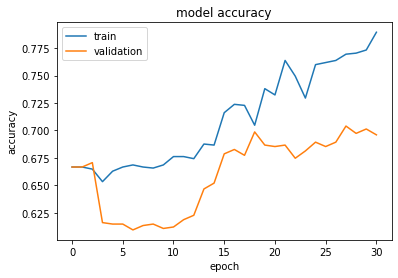

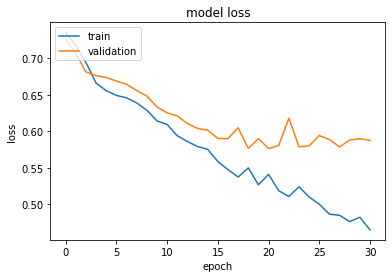

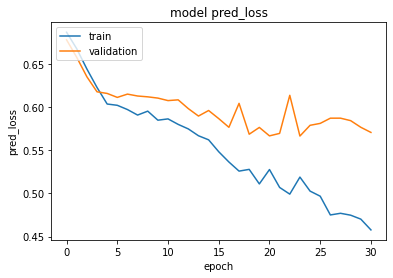

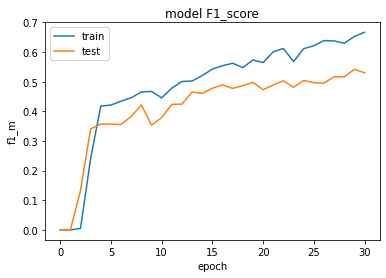

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Test_4
Une Couche avec 1024

In [17]:
MODEL_FILE_PATH = '/content/drive/MyDrive/Models_a_ameliorer'
MODEL_FILE_NAME = 'Test_4.h5'
LR=0.0001
batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500
encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(1024,return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])
    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    return (fct_loss, z) 
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()
def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(  LSTM(1024, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  

In [18]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 0.7354 - decoded_mean_loss: 0.0484 - pred_loss: 0.6864 - decoded_mean_acc: 0.0052 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00     

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/Models_a_ameliorer/Test_4.h5
350/350 [==============================] - 214s 612ms/sample - loss: 0.7354 - decoded_mean_loss: 0.0484 - pred_loss: 0.6864 - decoded_mean_acc: 0.0052 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00 - val_loss: 0.7207 - val_decoded_mean_loss: 0.0485 - val_pred_loss: 0.6720 - val_decoded_mean_acc: 0.4472 - val_decoded_mean_f1_m: 0.0000e+00 - val_decoded_mean_precision_m: 0.0000e+00 - val_decoded_mean_recall_m: 0.0000e+00 - val_pred_acc: 0.6667 - val_pred_f1_m: 0.0000e+00 - val_pred_precision_m: 0.0000e+00 - val_pred_recall_m: 0.0000e+00
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.7134 - decoded_mean_loss: 0.0486 - pred_loss: 0.6619 - decoded_mean_acc: 0.6704 - decoded_mean_f1_

In [19]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.5959127554893494,
 0.015163834,
 0.57894456,
 0.92932,
 0.9515705,
 0.99023974,
 0.9158084,
 0.6986667,
 0.5367969,
 0.55016345,
 0.52433896]

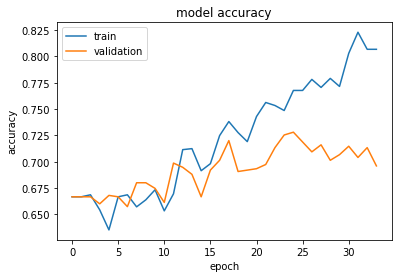

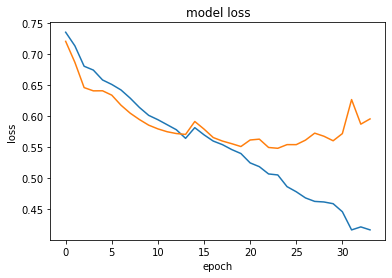

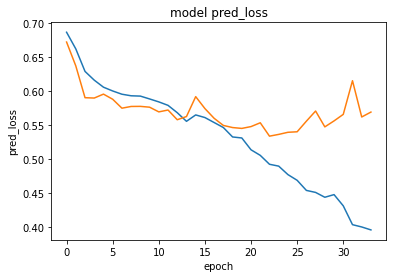

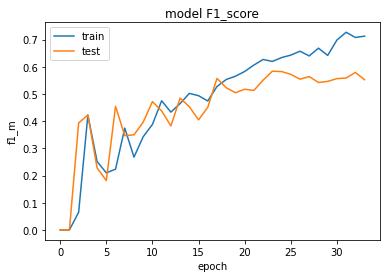

In [20]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/Models_a_ameliorer'
MODEL_FILE_NAME = 'Test_5.h5'
LR=0.0001
batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500
encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(1250,return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])
    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    return (fct_loss, z) 
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()
def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(  LSTM(1250, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
200/350 [================>.............] - ETA: 1:23 - loss: 0.7395 - decoded_mean_loss: 0.0484 - pred_loss: 0.6911 - decoded_mean_acc: 0.0000e+00 - decoded_mean_f1_m: 0.0000e+00 - decoded_mean_precision_m: 0.0000e+00 - decoded_mean_recall_m: 0.0000e+00 - pred_acc: 0.6667 - pred_f1_m: 0.0000e+00 - pred_precision_m: 0.0000e+00 - pred_recall_m: 0.0000e+00

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **Test_5** :
Deux couches cachés avec 1024 et 500 Neurones pour chaqu'une


In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'Test_6.h5'
LR=0.0001

batch_size = 100
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(975, return_sequences=True,dropout=0.25),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Bidirectional(LSTM(500, return_sequences=False,dropout=0.25),merge_mode='concat')(h)
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(LSTM(1024, return_sequences=True, name='dec_lstm_1',dropout=0.25))(repeated_context)
    h = Bidirectional(LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.25))(h)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy',f1_m,precision_m, recall_m])
autoencoder.summary()


In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_f1_m'])
plt.plot(history.history['val_pred_f1_m'])

plt.title('model F1_score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()